In [4]:
%matplotlib inline
from utils import *
from tqdm import *
from os.path import join
from matplotlib import pyplot as plt
from skimage.measure import block_reduce
from multiprocessing import Pool
import numpy as np
import librosa

In [5]:
data_root = 'drumData'
n_fft = 1024
hop_length = n_fft/4
use_logamp = False # boost the brightness of quiet sounds
reduce_rows = 10 # how many frequency bands to average into one
reduce_cols = 1 # how many time steps to average into one
crop_rows = 32 # limit how many frequency bands to use
crop_cols = 32 # limit how many time steps to use
limit = None # set this to 100 to only process 100 samples

In [6]:
drumNames = ["kick", "tom", "snare", "clap", "hi.hat", "ride", "crash"]
drumFingerPrints = {}
drumSamples = {}
for d in drumNames:
    %time drumSamples[d] = np.load(join(data_root, d+'_samples.npy'))

CPU times: user 1.18 ms, sys: 174 ms, total: 176 ms
Wall time: 484 ms
CPU times: user 626 µs, sys: 14.2 ms, total: 14.8 ms
Wall time: 39.8 ms
CPU times: user 1.19 ms, sys: 86.1 ms, total: 87.3 ms
Wall time: 237 ms
CPU times: user 540 µs, sys: 43.2 ms, total: 43.7 ms
Wall time: 125 ms
CPU times: user 758 µs, sys: 5.96 ms, total: 6.72 ms
Wall time: 15.7 ms
CPU times: user 810 µs, sys: 8.51 ms, total: 9.32 ms
Wall time: 22 ms
CPU times: user 1.56 ms, sys: 26.1 ms, total: 27.6 ms
Wall time: 67.7 ms


In [10]:
print (len(drumSamples))

7


In [14]:
crashes = drumSamples["crash"]

In [15]:
print (crashes.shape)

(723, 12000)


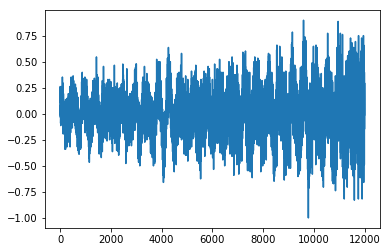

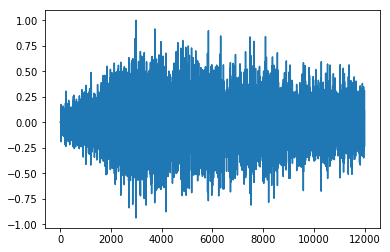

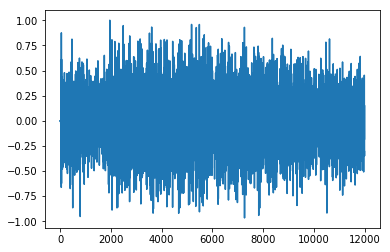

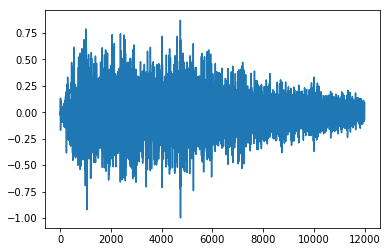

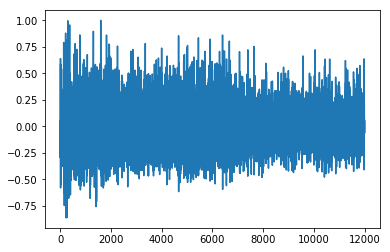

In [21]:
for i in range(5):
    plt.figure()
    plt.plot(crashes[i])

In [22]:
y, sr = librosa.load(crashes[0])
centroid = ibrosa.feature.spectral_centroid(y=y, sr=sr)
print(centroid.shape)

AttributeError: 'numpy.ndarray' object has no attribute 'startswith'

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from time import time
from utils import *
from os.path import join
from multiprocessing import Pool
import numpy as np
import itertools
import time as timeMod
from time import mktime
from datetime import datetime
import scipy.spatial
import scipy.spatial.distance as dist 
import python_speech_features as psf
import pickle
from skimage.measure import block_reduce

In [2]:
data_root = 'drumData/'
sr = 48000 # this is the samplerate initially used to load the samples
drumNames = pickle.load(open(data_root+'drumNames.pickle'))
drumLengths = pickle.load(open(data_root+'drumLengths.pickle'))
drumMFCCs = {}
for d in drumNames:
    %time drumSamples[d] = np.load(join(data_root, d+'_samples.npy'))
n_fft = 1024
hop_length = n_fft/4
use_logamp = False # boost the brightness of quiet sounds
reduce_rows = 10 # how many frequency bands to average into one
reduce_cols = 1 # how many time steps to average into one
crop_rows = 32 # limit how many frequency bands to use
crop_cols = 32 # limit how many time steps to use
limit = None # set this to 100 to only process 100 samples

IOError: [Errno 2] No such file or directory: 'drumData/drumNames.pickle'